In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'  # Asegura compatibilidad para TensorFlow.js

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers

# Rutas del dataset
train_path = "/content/drive/MyDrive/Colab Notebooks/Proyecto Final/dataset/dataset/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/Proyecto Final/dataset/dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Cargar datasets
raw_train_dataset = image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ✅ Data Augmentation realista para señales viales
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

# Aplicar aumento de datos al dataset de entrenamiento
train_dataset = raw_train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Aplicar el preprocesamiento de MobileNetV2
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

Found 2888 files belonging to 6 classes.
Found 720 files belonging to 6 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

IMG_SIZE = 224
NUM_CLASSES = 6

# Nueva entrada
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_layer")

# Cargar MobileNetV2 como base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)
base_model.trainable = False  # Congelar pesos de la base

# Agregar nuevas capas densas
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Regularización
output = layers.Dense(NUM_CLASSES, activation='softmax', name="output")(x)

model = models.Model(inputs=input_tensor, outputs=output)
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_layer[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Compilación con learning rate ajustado
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback para evitar sobreentrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenamiento con callback
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
91/91 [==============================] - 142s 1s/step - loss: 1.8399 - accuracy: 0.2836 - val_loss: 1.3502 - val_accuracy: 0.5431
Epoch 2/100
91/91 [==============================] - 40s 439ms/step - loss: 1.2779 - accuracy: 0.5242 - val_loss: 1.0409 - val_accuracy: 0.6569
Epoch 3/100
91/91 [==============================] - 40s 438ms/step - loss: 1.0569 - accuracy: 0.6170 - val_loss: 0.8404 - val_accuracy: 0.7431
Epoch 4/100
91/91 [==============================] - 40s 439ms/step - loss: 0.8857 - accuracy: 0.6804 - val_loss: 0.7321 - val_accuracy: 0.7778
Epoch 5/100
91/91 [==============================] - 40s 439ms/step - loss: 0.7971 - accuracy: 0.7244 - val_loss: 0.6446 - val_accuracy: 0.8083
Epoch 6/100
91/91 [==============================] - 41s 440ms/step - loss: 0.7141 - accuracy: 0.7514 - val_loss: 0.5917 - val_accuracy: 0.8153
Epoch 7/100
91/91 [==============================] - 40s 439ms/step - loss: 0.6542 - accuracy: 0.7715 - val_loss: 0.5602 - val_accuracy: 0

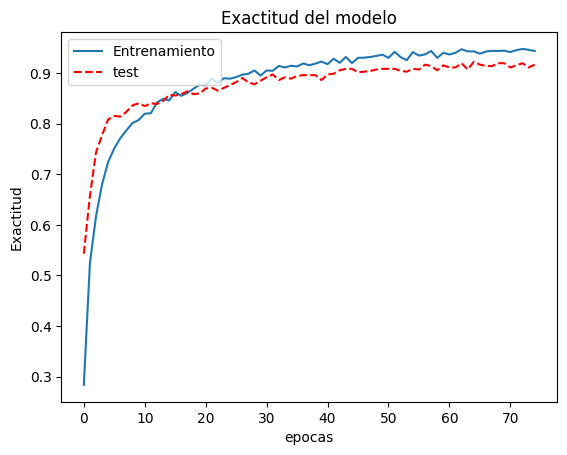

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],'r--')
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

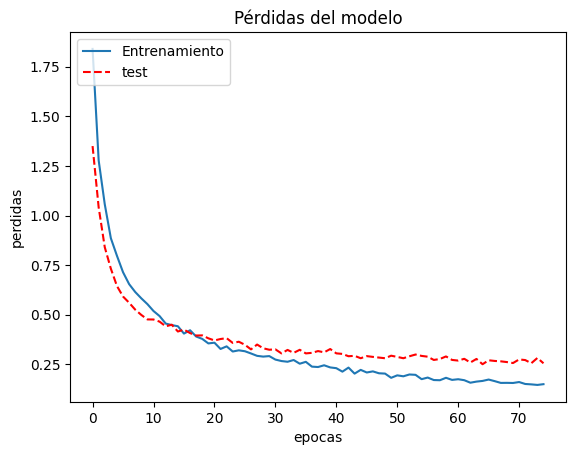

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'r--')
plt.title('Pérdidas del modelo')
plt.ylabel('perdidas')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'test'], loc='upper left')
plt.show()

23/23 [==============================] - 2s 50ms/step


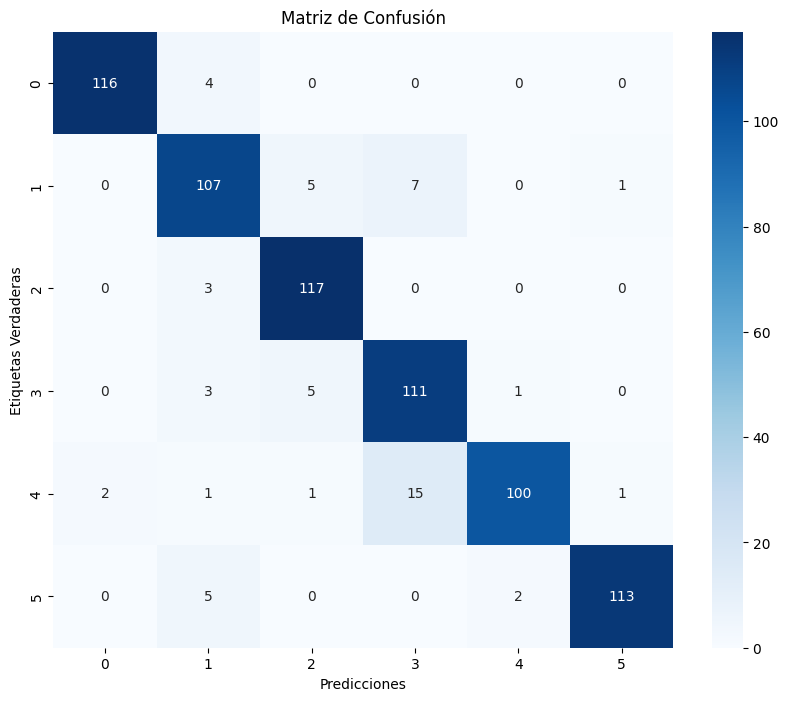

In [8]:
# prompt: Genera la matriz de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener predicciones del conjunto de prueba
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = []
for images, labels in test_dataset:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))

# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Verdaderas")
plt.title("Matriz de Confusión")
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Imprimir el reporte por clase
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       120
           1       0.87      0.89      0.88       120
           2       0.91      0.97      0.94       120
           3       0.83      0.93      0.88       120
           4       0.97      0.83      0.90       120
           5       0.98      0.94      0.96       120

    accuracy                           0.92       720
   macro avg       0.93      0.92      0.92       720
weighted avg       0.93      0.92      0.92       720



In [10]:
cd /content/drive/MyDrive/Colab Notebooks/Proyecto Final/Modelo

/content/drive/MyDrive/Colab Notebooks/Proyecto Final/Modelo


In [11]:
# Guardar el modelo en formato HDF5
model.save('model.h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
!pip install tensorflowjs
import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [13]:
#Convertir el modelo de h5 a JS (sin ninguna optimización)
!mkdir tensorflowjs-model
!tensorflowjs_converter --input_format=keras model.h5 tensorflowjs-model/

2025-06-02 02:16:01.255635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748830561.276928   19613 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748830561.283409   19613 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


In [14]:
#Comprimir la carpeta del modelo para descargarla de manera local
#Este archivo zip se utilizará en la página web para probar nuestro modelo
!zip -r tensorflowjs-model.zip tensorflowjs-model

  adding: tensorflowjs-model/ (stored 0%)
  adding: tensorflowjs-model/group1-shard1of3.bin (deflated 7%)
  adding: tensorflowjs-model/group1-shard2of3.bin (deflated 7%)
  adding: tensorflowjs-model/group1-shard3of3.bin (deflated 7%)
  adding: tensorflowjs-model/model.json (deflated 96%)
